In [2]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models
from dataset import UTKDataset
import numpy as np
import pickle
from cautious_extrapolation.utils import AverageMeter, string_to_dict
from cautious_extrapolation.data_paths import DATA_PATHS
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [121]:
def validate(loader, model):
    model.eval()

    outputs_all = np.zeros((len(loader.dataset)))

    with torch.no_grad():
        for i, (xs, ys) in enumerate(loader):

            xs = xs.cuda()
            ys = ys.cuda()

            x = model.CNN(xs)

            for layer in range(6):
                xs = model.CNN.CNN[layer](xs)
            xs = xs - model.CNN.CNN[layer].bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
            outputs_all[i*loader.batch_size:(i+1)*loader.batch_size] = np.linalg.norm(xs.reshape((len(xs), -1)).cpu().numpy(), axis=1)

    return outputs_all

run_name = "seed0_2023_06_12_17_43_26"
checkpoint_name = os.path.join("data", run_name, "best.th")

model = models.NN()
print("loading checkpoint '{}'".format(checkpoint_name))
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()

cudnn.benchmark = True

In [148]:
corruption_type = "impulse_noise"

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.23,))
])

dataFrame = pd.read_csv(os.path.join(DATA_PATHS["nfs"]["UTKFace"], 'age_gender.gz'), compression='gzip')
train_dataFrame, val_dataFrame = train_test_split(dataFrame, test_size=0.2, random_state=42)

val_loader = torch.utils.data.DataLoader(
    UTKDataset(val_dataFrame, transform=normalize),
    batch_size=64, shuffle=False,
    num_workers=4)

ood_loaders = []
for corruption_level in range(5):
    ood_loader = torch.utils.data.DataLoader(
        UTKDataset(val_dataFrame, severity=corruption_level+1, transform=normalize, corruption_type=corruption_type),
        batch_size=64, shuffle=False,
        num_workers=4)
    ood_loaders.append(ood_loader)


results_impulse_noise = {}
outputs_all = validate(val_loader, model)
results_impulse_noise[0] = outputs_all

for corruption_level in range(5):
    outputs_all = validate(ood_loaders[corruption_level], model)
    results_impulse_noise[corruption_level+1] = outputs_all


In [123]:
corruption_type = "gaussian_blur"


normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.23,))
])

dataFrame = pd.read_csv(os.path.join(DATA_PATHS["nfs"]["UTKFace"], 'age_gender.gz'), compression='gzip')
train_dataFrame, val_dataFrame = train_test_split(dataFrame, test_size=0.2, random_state=42)

val_loader = torch.utils.data.DataLoader(
    UTKDataset(val_dataFrame, transform=normalize),
    batch_size=64, shuffle=False,
    num_workers=4)

ood_loaders = []
for corruption_level in range(5):
    ood_loader = torch.utils.data.DataLoader(
        UTKDataset(val_dataFrame, severity=corruption_level+1, transform=normalize, corruption_type=corruption_type),
        batch_size=64, shuffle=False,
        num_workers=4)
    ood_loaders.append(ood_loader)


results_gaussian_blur = {}
outputs_all = validate(val_loader, model)
results_gaussian_blur[0] = outputs_all

for corruption_level in range(5):
    outputs_all = validate(ood_loaders[corruption_level], model)
    results_gaussian_blur[corruption_level+1] = outputs_all


In [128]:
gaussian_blur_mean = []
gaussian_blur_std = []
impulse_noise_mean = []
impulse_noise_std = []
gaussian_blur_data = []
impulse_noise_data = []
for _ in range(6):
    gaussian_blur_mean.append(results_gaussian_blur[_].mean())
    gaussian_blur_std.append(results_gaussian_blur[_].std())
    gaussian_blur_data.append(results_gaussian_blur[_])
    impulse_noise_mean.append(results_impulse_noise[_].mean())
    impulse_noise_std.append(results_impulse_noise[_].std())
    impulse_noise_data.append(results_impulse_noise[_])

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


([<matplotlib.axis.YTick at 0x7f1f2edae410>,
 [Text(0, 0, '\\textbf{0}'),
  Text(0, 50, '\\textbf{50}'),
  Text(0, 100, '\\textbf{100}'),
  Text(0, 150, '\\textbf{150}'),
  Text(0, 200, '\\textbf{200}')])

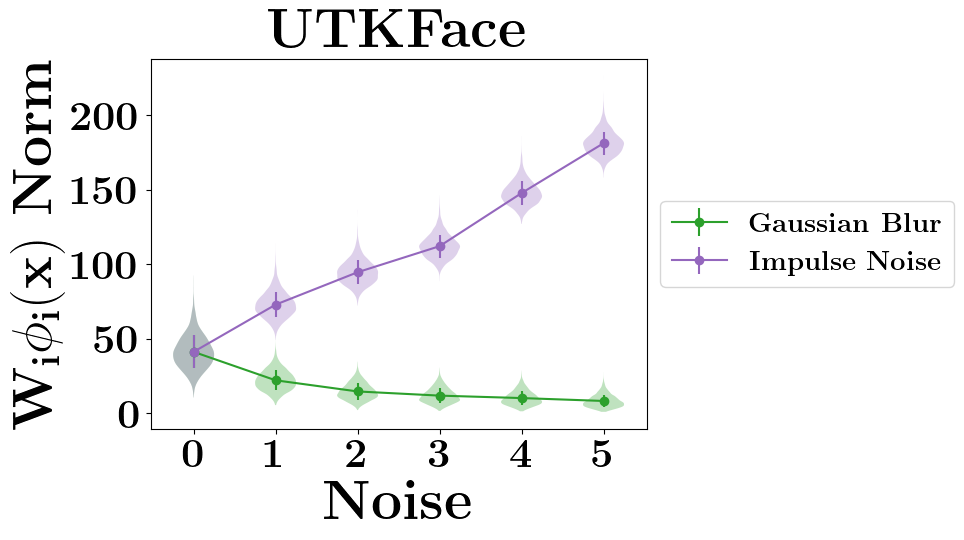

In [164]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

violin_parts = plt.violinplot(gaussian_blur_data, showextrema=False, positions=[i for i in range(6)])
plt.errorbar(range(6), gaussian_blur_mean, yerr=gaussian_blur_std, marker="o", label=r"\textbf{Gaussian Blur}", c="C2")
for vp in violin_parts['bodies']:
    vp.set_facecolor("C2")
violin_parts = plt.violinplot(impulse_noise_data, showextrema=False, positions=[i for i in range(6)])
plt.errorbar(range(6), impulse_noise_mean, yerr=impulse_noise_std, marker="o", label=r"\textbf{Impulse Noise}", c="C4")
for vp in violin_parts['bodies']:
    vp.set_facecolor("C4")

#put legend on right of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

plt.xlabel(r"\textbf{Noise}", fontsize=40)
plt.ylabel(r"$\mathbf{W_i \phi_i(x)}$"+r"\textbf{ Norm}", fontsize=40)
plt.title(r"\textbf{UTKFace}", fontsize=40)

plt.xticks(range(6), [r"\textbf{0}", r"\textbf{1}", r"\textbf{2}", r"\textbf{3}", r"\textbf{4}", r"\textbf{5}"], fontsize=30)
plt.yticks([_*50 for _ in range(5)], [r"\textbf{"+str(_*50)+"}" for _ in range(5)], fontsize=30)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


Text(0.5, 1.0, '\\textbf{Impulse Noise (5)}')

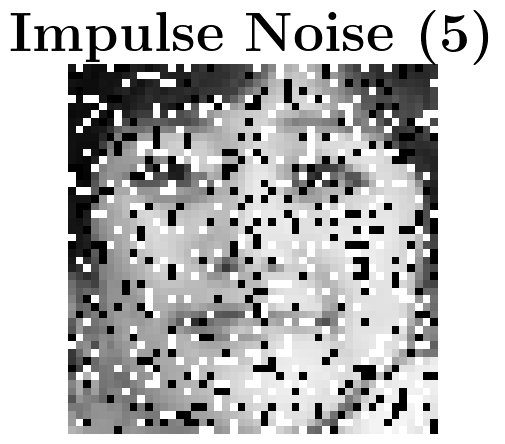

In [159]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

plt.imshow(UTKDataset(val_dataFrame, severity=5, transform=normalize, corruption_type="impulse_noise")[10][0].squeeze(), cmap='gray')
plt.axis('off')
plt.title(r"\textbf{Impulse Noise (5)}", fontsize=40)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


Text(0.5, 1.0, '\\textbf{Gaussian Blur (5)}')

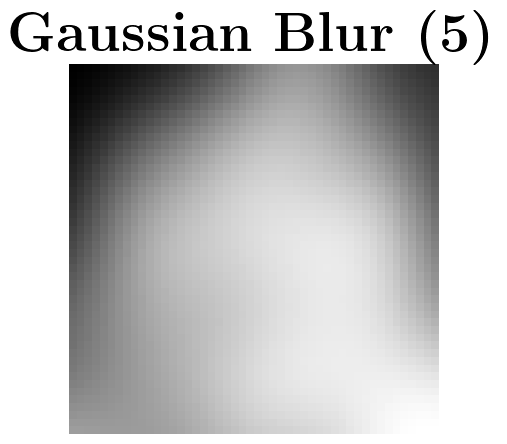

In [160]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

plt.imshow(UTKDataset(val_dataFrame, severity=5, transform=normalize, corruption_type="gaussian_blur")[10][0].squeeze(), cmap='gray')
plt.axis('off')
plt.title(r"\textbf{Gaussian Blur (5)}", fontsize=40)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


Text(0.5, 1.0, '\\textbf{Original (0)}')

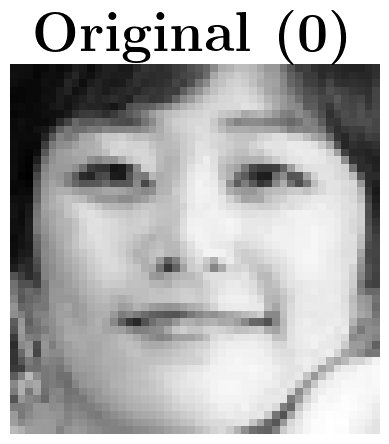

In [161]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

plt.imshow(UTKDataset(val_dataFrame, severity=0, transform=normalize, corruption_type="gaussian_blur")[10][0].squeeze(), cmap='gray')
plt.axis('off')
plt.title(r"\textbf{Original (0)}", fontsize=40)